## Imports

In [6]:
import numpy as np
import random
import statistics
from statistics import median
import matplotlib.pyplot as plt # Para graficar la distribución
from scipy import stats
import pywt

## Funciones necesarias

### pdfcdfcontinua

In [2]:
def pdfcdfcontinua(datos, minimo=None, maximo=None, particiones=None):
    """
    Estima la función de densidad (PDF) y la función de distribución acumulativa (CDF)
    de una muestra aleatoria `datos` usando histogramas.
    """

    datos = np.ravel(datos)
    total = len(datos)

    if minimo is None or maximo is None:
        rango = np.max(datos) - np.min(datos)
        minimo = np.min(datos) - 0.02 * rango
        maximo = np.max(datos) + 0.02 * rango

    print(minimo, maximo)

    if particiones is None:
        particiones = int(np.floor(np.sqrt(total)))

    bins = np.linspace(minimo, maximo, particiones + 1)

    # Histograma normalizado (densidad=True) para obtener PDF
    fr, edges = np.histogram(datos, bins=bins, density=False)
    ancho_bin = edges[1] - edges[0]
    pdf = fr / (total * ancho_bin)

    # CDF como suma acumulativa de las frecuencias normalizadas
    cdf = np.cumsum(fr) / total

    x = edges[:-1] + ancho_bin / 2  # Coordenadas del centro de cada bin

    # Gráficas
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    axs[0].plot(x, pdf, linewidth=2)
    axs[0].set_title("Estimación de la función de densidad")
    axs[0].set_xlabel("$x$")
    axs[0].set_ylabel("$f_X(x)$")
    axs[0].grid(True)

    axs[1].plot(x, cdf, linewidth=2)
    axs[1].set_title("Estimación de la Distribución Acumulativa")
    axs[1].set_xlabel("$x$")
    axs[1].set_ylabel("$F_X(x)$")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

### superfuncion

In [3]:
def superfuncion(datos, nombre='aleatorio'):
    if datos is None or len(datos) == 0:
        print("Falta el vector de datos")
        return

    p = np.linspace(0, 1, 100000)
    datos = 1.0000000001 * np.array(datos).flatten()
    numero = np.quantile(datos, p)

    encabezado = f"def {nombre}(m, n):"
    cuerpo = f"    numero = {numero.tolist()}"
    final = (
        "    import numpy as np\n"
        "    if m == 1:\n"
        "        return np.transpose(np.random.choice(numero, (n,)))\n"
        "    else:\n"
        "        return np.random.choice(numero, (m, n))"
    )

    with open(f"{nombre}.py", "w") as f:
        f.write(encabezado + "\n")
        f.write(cuerpo + "\n")
        f.write(final + "\n")

    print(f"{nombre}.py generado. Revisa tu carpeta actual.")
    print(f"Luego puedes ejecutar: from {nombre} import {nombre}; {nombre}(m,n)")

In [53]:
# BCpAug89
datosAug = np.loadtxt("./BCpAug89.TL")
muestraAgosto = np.diff(datosAug[:, 0])

# BCpOct89
datosOct = np.loadtxt("./BCpOct89.TL")
muestraOctubre = np.diff(datosOct[:, 0])

# BCOct89Ext
datosOctExt = np.loadtxt("./BCOct89Ext.TL")
muestraOctubreExt = np.diff(datosOctExt[:, 0])

# BCOct89Ext4
datosOctExt4 = np.loadtxt("./BCOct89Ext4.TL")
muestraOctubreExt4 = np.diff(datosOctExt4[:, 0])

In [5]:
superfuncion(muestraAgosto, "agostoAleatorio")
superfuncion(muestraOctubreExt4, "octubreExt4Aleatorio")

agostoAleatorio.py generado. Revisa tu carpeta actual.
Luego puedes ejecutar: from agostoAleatorio import agostoAleatorio; agostoAleatorio(m,n)
octubreExt4Aleatorio.py generado. Revisa tu carpeta actual.
Luego puedes ejecutar: from octubreExt4Aleatorio import octubreExt4Aleatorio; octubreExt4Aleatorio(m,n)


In [6]:
import agostoAleatorio
import octubreExt4Aleatorio

In [7]:
muestraAgostosf = agostoAleatorio.agostoAleatorio(1, 1000000)
muestraAgostosf

array([0.003904, 0.004036, 0.00426 , ..., 0.003836, 0.001964, 0.001968],
      shape=(1000000,))

In [8]:
muestraOctubreExt4sf = octubreExt4Aleatorio.octubreExt4Aleatorio(1, 1000000)
muestraOctubreExt4sf

array([0.00422 , 0.000412, 0.017172, ..., 0.003848, 0.006332, 0.147184],
      shape=(1000000,))

## vt

In [42]:

def _pendienteci(x, y):
    """
    Regresión lineal simple (mínimos cuadrados) y cálculo de intervalo de confianza al 95% para la pendiente.

    Parámetros
    ----------
    x : 1D array
        Variable independiente (log10(m)).
    y : 1D array
        Variable dependiente (log10(varianza)).

    Devuelve
    -------
    m : float
        Pendiente de la recta.
    b : float
        Ordenada al origen de la recta.
    ml : float
        Límite inferior de intervalo de confianza (95%) para m.
    mh : float
        Límite superior de intervalo de confianza (95%) para m.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = x.size
    if n < 3:
        raise ValueError("Se requieren al menos 3 puntos para realizar regresión.")

    # Cálculo de parámetros de la recta: m y b
    A = np.dot(x, x)
    B = x.sum()
    C = np.dot(x, y)

    x_mean = x.mean()
    y_mean = y.mean()

    m = (C - B * y_mean) / (A - B * x_mean)
    b = y_mean - m * x_mean

    # Error residual
    y_pred = m * x + b
    error = y - y_pred
    s = np.sqrt(np.dot(error, error) / (n - 2))

    # Sxx = sum((x - x_mean)^2)
    ex = x - x_mean
    Sxx = np.dot(ex, ex)

    # t critico para 95% en n-2 grados de libertad
    tval = stats.t.ppf(0.975, df=n - 2)

    # Intervalo de confianza para la pendiente m
    ml = m - tval * s / np.sqrt(Sxx)
    mh = m + tval * s / np.sqrt(Sxx)

    return m, b, ml, mh

def vt(traza):
    """
    Diagrama Varianza–Tiempo y estimación del parámetro de Hurst.

    Parámetros
    ----------
    traza : array_like, 1D
        Vector de datos (serie de tiempo) sobre el cual se calcula el diagrama varianza–tiempo.

    Devuelve
    -------
    H     : float
        Estimación del parámetro de Hurst (punto medio de la recta).
    Hmin  : float
        Límite inferior del intervalo de confianza al 95% para H.
    Hmax  : float
        Límite superior del intervalo de confianza al 95% para H.

    Además, la función dibuja (en pantalla) el diagrama log10(varianza) vs. log10(m)
    junto con la recta de regresión lineal y su intervalo de confianza.
    """
    traza = np.asarray(traza).flatten()
    L = traza.size

    # gruposmax = fix(L / sqrt(L)) en MATLAB equivale a floor(sqrt(L))
    gruposmax = int(np.floor(np.sqrt(L)))
    if gruposmax < 2:
        raise ValueError("La longitud de 'traza' es demasiado pequeña para calcular vt().")

    # Reservamos un arreglo para varianza; tendrá longitud (gruposmax - 1)
    varianza = np.zeros(gruposmax - 1, dtype=float)

    # Para cada n = 2 ... gruposmax, calculamos:
    #   columnas = fix(L / n)
    #   datos  = reshape(traza(1 : n*columnas), [n, columnas])
    #   varianza(n-1) = var(promedios), donde promedios = mean(datos) (promedio por columna)
    for idx, n in enumerate(range(2, gruposmax + 1)):
        columnas = int(np.floor(L / n))
        if columnas < 1:
            # si columnas=0, no podemos reshape; salir del bucle
            break

        # Reproducimos reshape(..., [n, columnas]) de MATLAB (que rellena por columnas).
        bloque = traza[: n * columnas]
        datos = bloque.reshape((n, columnas), order='F')

        # promedio de cada columna (dim=0) y varianza muestral (ddof=1)
        promedios = datos.mean(axis=0)
        varianza[idx] = np.var(promedios, ddof=1)

    # Tomamos sólo los índices válidos (en caso de que el bucle se haya roto antes)
    Npts = idx + 1
    varianza = varianza[:Npts]

    # Construimos x = log10(m) para m = 2,3,...,2+Npts-1
    m_vals = np.arange(2, 2 + Npts)
    x = np.log10(m_vals)
    y = np.log10(varianza)

    # Regresión lineal con intervalo de confianza
    m_slope, b_intercept, ml, mh = _pendienteci(x, y)

    H     = m_slope / 2 + 1
    Hmin  = ml / 2 + 1
    Hmax  = mh / 2 + 1

    # --- Visualización del diagrama ---
    fig, ax = plt.subplots(figsize=(8, 5))
    # Puntos experimentales
    ax.plot(x, y, 's', markerfacecolor='b', markeredgecolor='k', label=r'$\log S_{X^{(m)}}^2$')

    # Recta de regresión: y_hat = m_slope * x + b_intercept
    y_hat = m_slope * x + b_intercept
    ax.plot(x, y_hat, 'r', linewidth=2, label='Regresión Lineal')

    # Intervalo de confianza (líneas punteadas)
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # Definimos x1, x2 tal como en MATLAB (0.45 y 0.55 del rango)
    x1 = xmin + 0.45 * (xmax - xmin)
    x2 = xmin + 0.55 * (xmax - xmin)
    y1 = m_slope * x1 + b_intercept
    y2 = m_slope * x2 + b_intercept

    # Dibujamos: una línea vertical en x = x1 desde y1 hasta y2, y luego la horizontal en y = y2 de x1 a x2
    ax.plot([x1, x1, x2], [y1, y2, y2], 'k:', linewidth=2)

    # Ajustes estéticos
    ax.set_title('Diagrama Varianza - Tiempo', fontsize=18)
    ax.set_xlabel(r'$\log m$', fontsize=18)
    ax.set_ylabel(r'$\log S_{X^{(m)}}^2$', fontsize=18)
    ax.grid(True)
    ax.set_xlim(xmin, xmax)
    delta_y = ymax - ymin
    ax.set_ylim(ymin - 0.1 * delta_y, ymax + 0.1 * delta_y)
    ax.tick_params(labelsize=16)
    ax.legend(loc='best', fontsize=14, frameon=False)
    fig.patch.set_facecolor('white')

    plt.show()

    return H, Hmin, Hmax



## ld

In [13]:
def LD(traza):
    """
    Diagrama Log–Escala (LD) vía transformada wavelet de Haar.

    Parámetros
    ----------
    traza : array_like, 1D
        Serie de datos (vector) de entrada.

    Devuelve
    -------
    H     : float
        Estimación del parámetro de Hurst (punto medio).
    alpha : float
        Pendiente de la regresión lineal en el diagrama log–escala.

    Además, la función dibuja el diagrama log–escala y la recta de regresión
    entre las octavas j1=2 y j2=N-1 (donde N = floor(log2(len(traza))/2 + 1)).
    """
    # Convertir a 1D de NumPy
    X = np.asarray(traza).flatten()
    L = X.size

    # Parámetros por defecto (versión 2.0)
    wavelet = 'db1'  # Haar
    j1 = 2
    N = int(np.floor(np.log2(L) / 2 + 1))  # floor(log2(length)/2 + 1)
    j2 = N - 1

    # Descomposición wavelet de nivel N
    # coeffs = [cA_N, cD_N, cD_{N-1}, ..., cD_1]
    coeffs = pywt.wavedec(X, wavelet, level=N)

    # Construir vector mu de tamaño N. Sólo usaremos índices 1..N-1
    mu = np.zeros(N, dtype=float)

    # Para i = 1 .. N-1, extraer detalle D_i y calcular mu[i] = mean(abs(D_i)^2)
    #   En pywt, el detalle a nivel i está en coeffs[-i].
    for i in range(1, N):
        D_i = coeffs[-i]
        mu[i] = np.mean(np.abs(D_i)**2)

    # Construir los vectores para graficar:
    #   j_all = 1,2,...,N-1   (longitud N-1)
    #   y_all = log2(mu[1]), log2(mu[2]), ..., log2(mu[N-1])
    j_all = np.arange(1, N)
    y_all = np.log2(mu[1:N])

    # Ajuste lineal (Mínimos Cuadrados) sobre j = j1 .. j2
    js = np.arange(j1, j2 + 1)               # [2, 3, ..., N-1]
    y_vals = np.log2(mu[j1:j2 + 1])          # log2(mu_j) para j=j1..j2

    coef = np.polyfit(js, y_vals, 1)
    alpha = coef[0]
    intercept = coef[1]

    # Cálculo de Hurst
    H = alpha / 2 + 0.5

    # Cálculo de intervalo de confianza para H (95%)
    j = j2 - j1
    nj1 = coeffs[-j1].size

    numer = 2 * (1 - 2**(-j))
    denom = nj1 * (np.log(2)**2) * (1 - 2**(-(j + 1)) * (j**2 + 4) + 2**(-2 * j))
    desviacion = np.sqrt(numer / denom)
    error = 1.9599 * desviacion  # t ≈ 1.96 para 95%

    Hmin = H - error
    Hmax = H + error

    # --- Gráfica del diagrama log–escala ---
    plt.figure(figsize=(8, 5))

    # Puntos experimentales: (j_all, y_all)
    plt.plot(j_all, y_all, 'b.', label=r'$\log_2(\mu_j)$')

    # Recta de regresión sólo sobre el tramo j1..j2
    #   Pero podemos extenderla para que cubra todo j_all.
    x_line = np.array([j_all.min(), j_all.max()])
    y_line = intercept + alpha * x_line
    plt.plot(x_line, y_line, 'r-', linewidth=2, label='Regresión Lineal')

    # Ajustes estéticos
    plt.title('Diagrama Log–Escala (LD)', fontsize=18)
    plt.xlabel(r'Octava $j$', fontsize=16)
    plt.ylabel(r'$y_j = \log_2(\mu_j)$', fontsize=16)
    plt.grid(True)
    plt.tick_params(labelsize=14)
    plt.legend([
        fr'Estimación: $H = {H:.4f}$',
        fr'IC 95\%: {Hmin:.4f} < H < {Hmax:.4f}'
    ], fontsize=12, loc='best')
    plt.gcf().patch.set_facecolor('white')
    plt.tight_layout()
    plt.show()

    return H, alpha


## betamwm

In [55]:
import numpy as np

def betamwm(Uoo, n, H, seed=None):
    """
    Versión universal de betamwm que admite Uoo escalar o vector.

    Parámetros:
    -----------
    Uoo : float o array_like
        Valor inicial (escalar) o vector (1D).
    n : int
        Número de iteraciones.
    H : float
        Exponente de Hurst (0 < H < 1).
    seed : int o None
        Semilla opcional para reproducibilidad.

    Retorna:
    --------
    traza : ndarray de longitud len(Uoo)*(2**n)
        Array 1D con la “traza” final después de n iteraciones.
    """
    if seed is not None:
        np.random.seed(seed)

    # Asegurarnos de que traza sea array 1D
    traza = np.array(Uoo, dtype=float).flatten()

    beta = (2**(2*H - 1) - 1) / (2 - 2**(2*H - 1))

    for i in range(1, n+1):
        # Antes de duplicar, traza tiene cierta longitud actual (m_old)
        m_old = traza.size

        # Generar m_old muestras Beta. Cada una genera dos valores en p.
        b = np.random.beta(beta, beta, size=m_old)

        # Ahora p de longitud 2*m_old = [b₁, 1-b₁, b₂, 1-b₂, …]
        p = np.empty(2 * m_old, dtype=float)
        p[0::2] = b
        p[1::2] = 1 - b

        # Duplicar cada valor de traza: [t1,t2,…] -> [t1,t1,t2,t2,…]
        traza = np.repeat(traza, 2)

        # Multiplicar elemento a elemento
        traza = traza * p

    return traza


# Actividad 1

## Prueba de sesgo

## Prueba de robustez

## Prueba de sesgo

In [3]:
# Parámetros de la distribución uniforme discreta
valor_minimo = 1
valor_maximo = 6
numero_de_muestras = 10000

In [4]:
muestras = np.random.randint(valor_minimo, valor_maximo + 1, size=numero_de_muestras)

In [60]:
print(f"Algunas muestras generadas (primeras 20): {muestras[:20]}")
print(f"Valor mínimo generado: {np.min(muestras)}")
print(f"Valor máximo generado: {np.max(muestras)}")

Algunas muestras generadas (primeras 20): [2 2 4 1 6 5 3 6 4 4 1 4 4 1 5 4 5 6 4 6]
Valor mínimo generado: 1
Valor máximo generado: 6


In [61]:
# Calcular la frecuencia de cada número
valores_unicos, conteos = np.unique(muestras, return_counts=True)
for valor, conteo in zip(valores_unicos, conteos):
    print(f"Valor: {valor}, Frecuencia: {conteo}, Probabilidad estimada: {conteo/numero_de_muestras:.4f}")

Valor: 1, Frecuencia: 1635, Probabilidad estimada: 0.1635
Valor: 2, Frecuencia: 1623, Probabilidad estimada: 0.1623
Valor: 3, Frecuencia: 1715, Probabilidad estimada: 0.1715
Valor: 4, Frecuencia: 1642, Probabilidad estimada: 0.1642
Valor: 5, Frecuencia: 1701, Probabilidad estimada: 0.1701
Valor: 6, Frecuencia: 1684, Probabilidad estimada: 0.1684


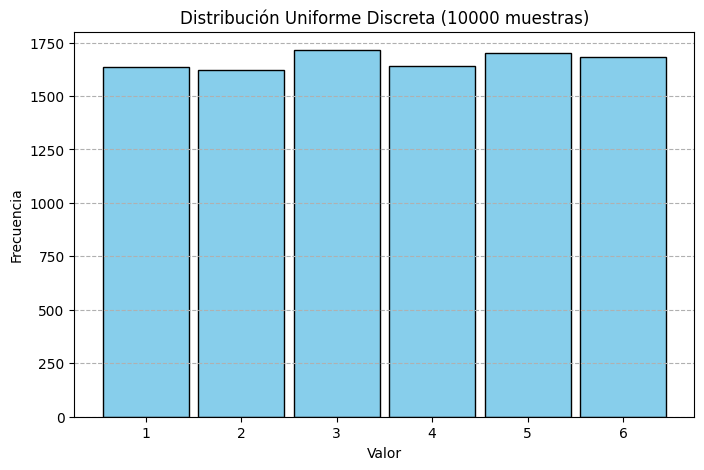

In [62]:
# Graficar el histograma de las muestras para visualizar la distribución
plt.figure(figsize=(8, 5))
plt.bar(valores_unicos, conteos, width=0.9, color='skyblue', edgecolor='black')
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.title(f"Distribución Uniforme Discreta ({numero_de_muestras} muestras)")
plt.xticks(range(valor_minimo, valor_maximo + 1)) # Asegurar que todos los valores del rango aparezcan en el eje x
plt.grid(axis='y', linestyle='--')
plt.show()

In [7]:
tamaño_muestra = 2000
muestra_aleatoria = random.sample(list(muestras), tamaño_muestra)

mediana_muestral = np.median(muestra_aleatoria)
media_muestral = statistics.mean(muestra_aleatoria)

valor_minimo = min(muestra_aleatoria)
valor_maximo = max(muestra_aleatoria)
rango_medio = (valor_maximo + valor_minimo) / 2

print (mediana_muestral)
print (media_muestral)
print (rango_medio)


tamaños_muestra = [100, 500, 1000, 2000]
resultados = {}

for tamaño in tamaños_muestra:
    medianas_muestrales = []
    for i in range(100):  # 100 muestras diferentes
        muestra = random.sample(list(muestras), tamaño)
        medianas_muestrales.append(median(muestra))
    
    resultados[tamaño] = {
        'media_medianas': np.mean(medianas_muestrales),
        'desviacion': np.std(medianas_muestrales)
    }
print(resultados)

3.0
3
3.5
{100: {'media_medianas': 3.495, 'desviacion': 0.4821566135603659}, 500: {'media_medianas': 3.63, 'desviacion': 0.47233462714478175}, 1000: {'media_medianas': 3.69, 'desviacion': 0.45705579528105755}, 2000: {'media_medianas': 3.785, 'desviacion': 0.4077683165720456}}


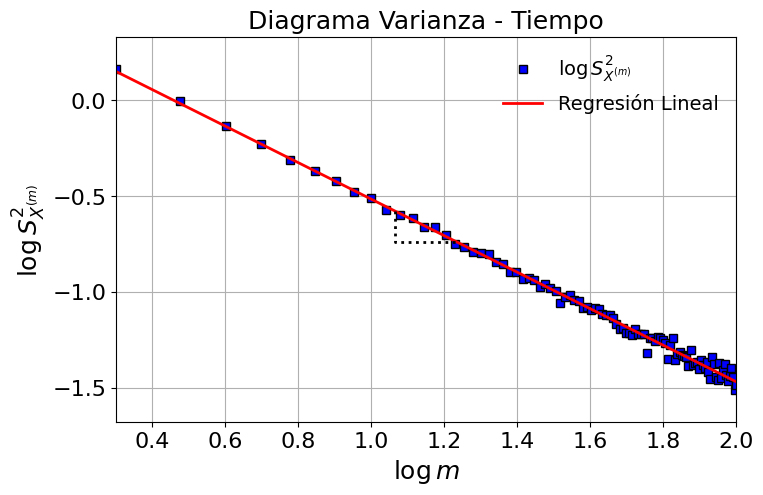

In [44]:
x, hmin, hmax =  vt(muestras)

In [46]:
print(x)
print(hmin)
print(hmax)

0.5238609472963482
0.5169006312575667
0.5308212633351297


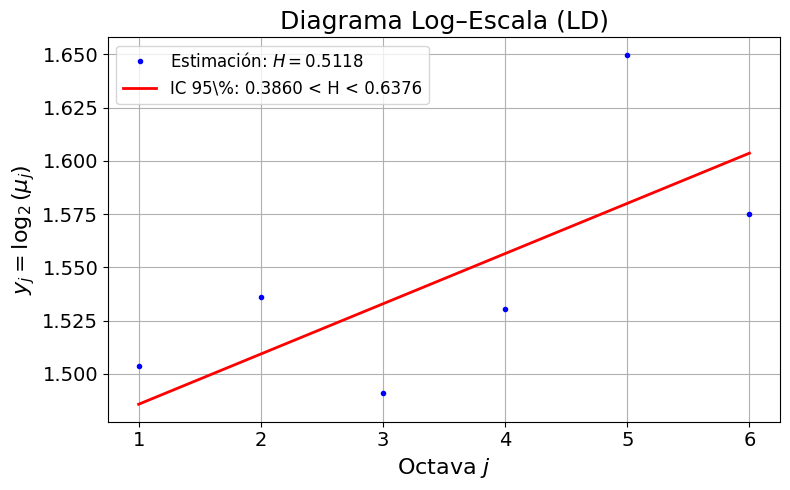

(np.float64(0.5117874281345441), np.float64(0.023574856269088312))

In [47]:
LD(muestras)

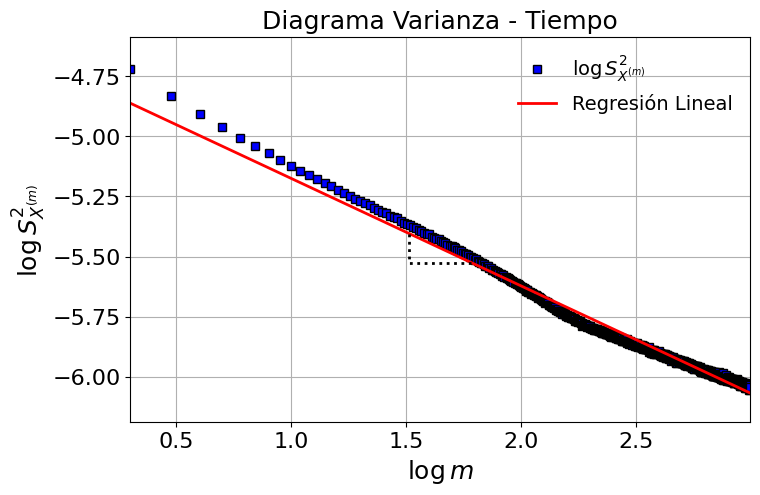

In [49]:
x, hmin, hmax =  vt(muestraAgosto)

In [50]:
x, hmin, hmax

(np.float64(0.7766189250779685),
 np.float64(0.7749990979680372),
 np.float64(0.7782387521878998))

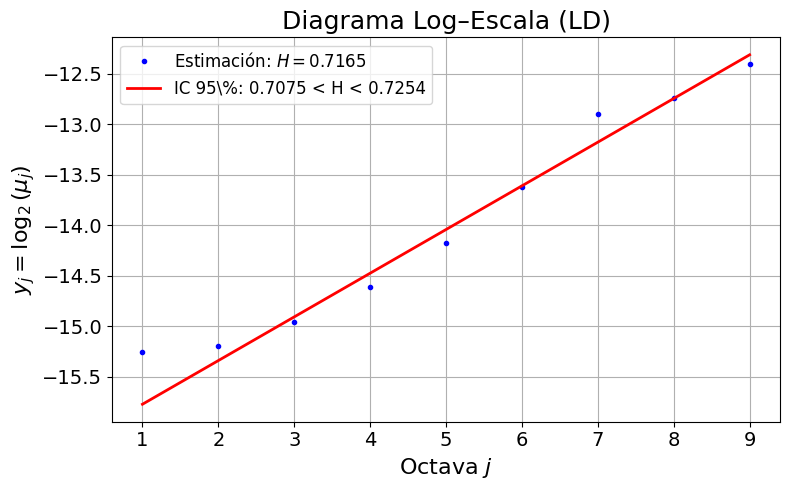

(np.float64(0.7164564323018916), np.float64(0.43291286460378325))

In [54]:
LD(muestraAgosto)

In [56]:
datos = betamwm(1,20,0.9)

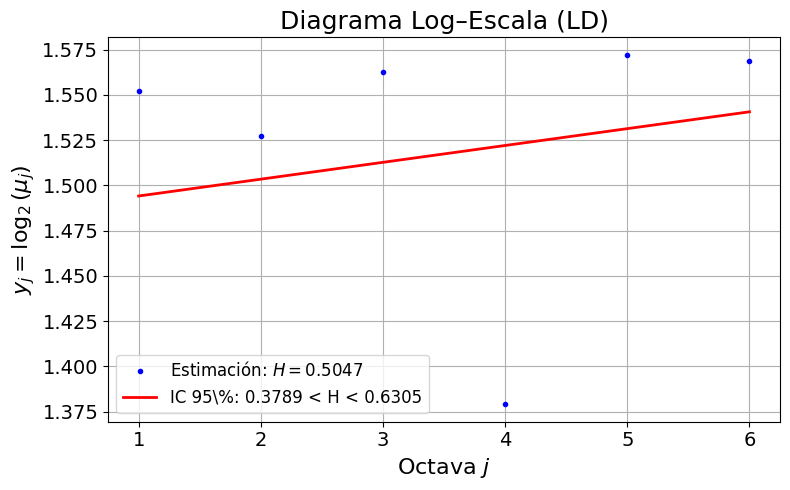

(np.float64(0.5046547102057889), np.float64(0.009309420411577845))

In [64]:
LD(muestras)

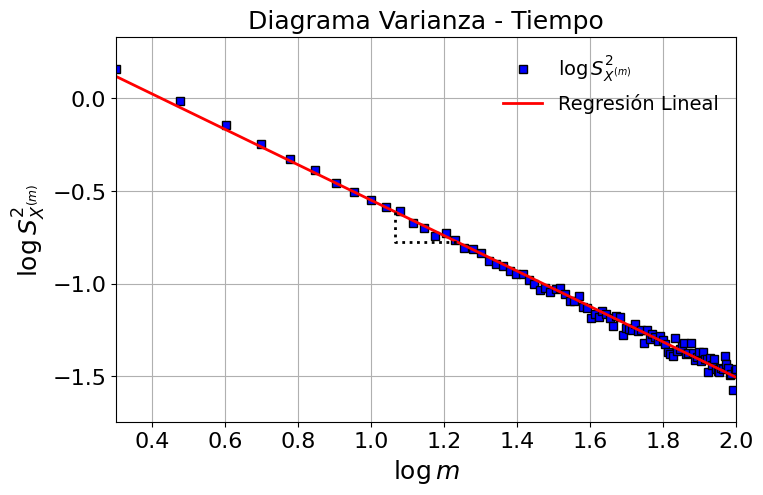

(np.float64(0.5226928484444168),
 np.float64(0.5149057608789415),
 np.float64(0.5304799360098921))

In [63]:
vt(muestras)